## Data Analysis - Singel Patient (BT02)

### Sampling Rate and NaN Analysis for Single Patient

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

def file_analysis(data_path: str) -> None:
    """Analyzes data files for NaN values and sampling rate consistency.
    
    Walks through the specified directory, identifies only the exoskeleton (_exo) and 
    biomechanical (_bio) CSV files and performs the following checks.
    1. Reports any columns containing NaN values.
    2. Aggregates and visualizes the sampling frequency by time.

    Args:
        data_path: The absolute or relative path to the directory that contains the data.

    Returns:
        None: Displays the analysis and plots in the notebook
    """
    
    files_processed = 0
    nan_report = []
    full_freqs = []
    freq_stats = []

    for root, dirs, files in os.walk(data_path):
        # get all file names
        for file in files:
        
            # only focusing on exo sensor and true data.
            if file.endswith("_exo.csv") or file.endswith("_moment_filt_bio.csv"):
                file_path = os.path.join(root, file)
                files_processed += 1
        
                df = pd.read_csv(file_path)
                
                # --- NULL ANALYSIS ---
                if df.isnull().values.any():
                    num_null = df.isnull().sum() # get total NAN values in each col
                    total_null = num_null.sum() # total NANs in dataset
                    cols_with_nulls = num_null[num_null > 0].index.tolist() # list of columsn with null values
                    null_col_df = df[cols_with_nulls].isna().sum() # data frame of cols_with_nulls & total null per col

                    nan_report.append({"File" : file, "Columns" : cols_with_nulls, "Count" : total_null})
                    
                # --- SAMPLING ANALYSIS ---
                if "exo.csv" in file and 'time' in df.columns:
                    time_diffs = np.diff(df["time"])
                    freqs = 1/time_diffs
                    full_freqs.extend(freqs) # combines sampling rates to aggregate for visualization

                    min_freq = np.min(freqs)
                    mean_freq = np.mean(freqs)  

                    # add dict containing sampling rate info to list
                    freq_stats.append({
                        "Name" : file,
                        "Minimum Frequency" : min_freq,
                        "Average Frequency" : mean_freq
                    })  

            

    if nan_report:
        print(f"NaN values found in {len(nan_report)} files")

        for item in nan_report:
            print(f"  - {item['File']}: {item['Count']} NaNs in {item['Columns']}")

    if full_freqs:
        full_sampling = np.array(full_freqs)

        # Calculate stats
        freq_mean = np.mean(full_sampling)
        freq_std = np.std(full_sampling)
        freq_min = min(full_sampling)
        freq_max = max(full_sampling)

        
        print(f'Sampling Rate for {data_path}')
        print(f'Mean Frequency: {freq_mean} Hz')
        print(f'Standard Deviation: {freq_std} Hz')
        print(f'Minimum: {freq_min} Hz')
        print(f'Maximum: {freq_max} Hz')

        # Visualization
        plt.figure()
        
        plt.hist(full_sampling, bins=100, color='blue', edgecolor = 'blue')
        plt.axvline(freq_mean, color='red', linestyle = '--', label=f'Mean: {freq_mean:.4f} Hz')
        plt.title(f"Sampling Rate Analysis (BT02)")
        plt.xlabel("Sampling Rate (Hz)")
        plt.ylabel("Count")
        #plt.ticklabel_format(useOffset=False)
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(min(full_sampling))


NaN values found in 166 files
  - BT02_poses_1_off_exo.csv: 78964 NaNs in ['hip_angle_l_torque_estimated', 'knee_angle_l_torque_estimated', 'hip_angle_r_torque_estimated', 'knee_angle_r_torque_estimated']
  - BT02_turn_and_step_1_left-turn_off_moment_filt_bio.csv: 35202 NaNs in ['hip_flexion_l_moment', 'hip_adduction_l_moment', 'hip_rotation_l_moment', 'knee_angle_l_moment', 'ankle_angle_l_moment', 'subtalar_angle_l_moment', 'hip_flexion_r_moment', 'hip_adduction_r_moment', 'hip_rotation_r_moment', 'knee_angle_r_moment', 'ankle_angle_r_moment', 'subtalar_angle_r_moment']
  - BT02_turn_and_step_1_left-turn_off_exo.csv: 25604 NaNs in ['hip_angle_l_torque_estimated', 'knee_angle_l_torque_estimated', 'hip_angle_r_torque_estimated', 'knee_angle_r_torque_estimated']
  - BT02_normal_walk_1_1_1-2_on_exo.csv: 16004 NaNs in ['hip_angle_l_torque_estimated', 'knee_angle_l_torque_estimated', 'hip_angle_r_torque_estimated', 'knee_angle_r_torque_estimated']
  - BT02_jump_1_1_vertical_on_exo.csv: 1440

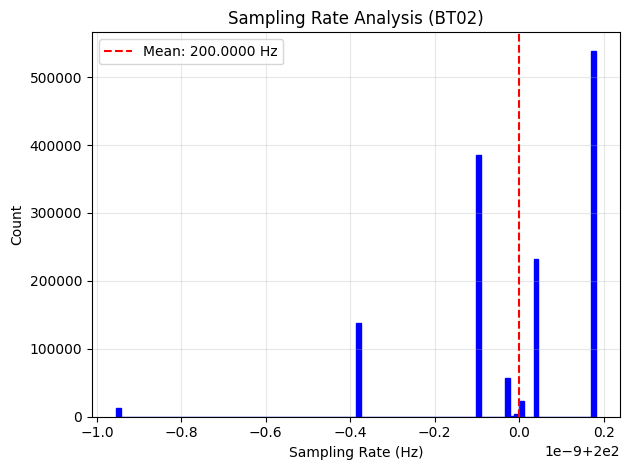

199.99999999904503


In [ ]:
data_path = "Phase1And2_Parsed/BT02"
file_analysis(data_path)

### Takeaways
- sampling rate is extremely consistnet with the sampling rate used by their instruments (200 Hz)
- high amount of NaNs, though when present they appear to be consistent for one timestep (i.e at a given time, all/no columns will have NaN values)
- [look into NaNs over time (are there large timeframes with/without data or are NaNs randomly scattered)]


## Diagnostic Plots

In [ ]:
def generate_diagnostic_plots(data_path) -> None:
    """ Generates diagnostic plots comparing exoskeleton sensor data with biomechanical moments.

    Matches `_exo.csv` files with their corresponding `_moment_filt_bio.csv` files.
    Plots the first 5 matching pairs found, displaying:
    1. Knee Angle vs. Knee Moment.
    2. Ground Reaction Force vs. Knee Angle.

    Args:
        data_path: The absolute or relative path to the directory containing the data.

    Returns:
        None: Plots displayed in notebook.
    """

    files_processed = 0
    print(data_path)
    for root, dirs, files in os.walk(data_path):
        for file in files:
    
            
            # only focusing on exo sensor and true data. other endings include: activity_flag, angle_filt, exo_sim, grf, imu_sim, isile_sim, momenent_filt, moment, power_bio, power_exo, power, velocity
            if file.endswith("_exo.csv"):
                moment_file = file.replace("_exo.csv", "_moment_filt_bio.csv")

                exo_path = os.path.join(root, file)
                moment_path = os.path.join(root, moment_file)


                # check if associated moment file exists
                if os.path.exists(moment_path):

                    # limit to first x files
                    if files_processed < 5:

                        df_exo = pd.read_csv(exo_path)
                        df_moment = pd.read_csv(moment_path)

                        fig, ax = plt.subplots(2, 1, sharex=True)
                        fig.suptitle(f"Diagnostic Plots for {file}")

                        # MOMENT AND ANGLE PLOTS
                        ax1 = ax[0]
                        ax1_right = ax1.twinx()

                        

                        if 'knee_angle_r' in df_exo.columns:
                            ax1.plot(df_exo['time'], df_exo['knee_angle_r'], 'b--', label = 'Right Knee Angle (deg)')
                            ax1.set_ylabel("Angle (deg)", color='b')
                        
                        if 'knee_angle_r_moment' in df_moment.columns:
                            ax1_right.plot(df_exo['time'], df_moment['knee_angle_r_moment'], 'r--', label = 'Right Knee Moment (Nm/kg)')
                            ax1_right.set_ylabel("Moment {Nm/kg}", color='r')
                      
                        ax1.set_title("1. Moment and Angles")



                        # GAIT PHASE
                        ax2 = ax[1]
                        ax2_right = ax2.twinx()

                        if 'insole_r_force_y' in df_exo.columns:
                            ax2.plot(df_exo['time'], df_exo['insole_r_force_y'], 'g-', label='Insole Force (N)')
                            ax2.set_ylabel('Force (N)', color='g')
                        elif 'insole_r_force_z' in df_exo.columns:
                            ax2.plot(df_exo['time'], df_exo['insole_r_force_z'], 'g-', label='Insole Force (N)')
                        
                        if 'knee_angle_r' in df_exo.columns:
                            ax2_right.plot(df_exo['time'], df_exo['knee_angle_r'], 'k:', label='Knee Angle')

                        ax2.set_title('Ground Force vs Knee Angle')


                        files_processed += 1



Parsed/BT02


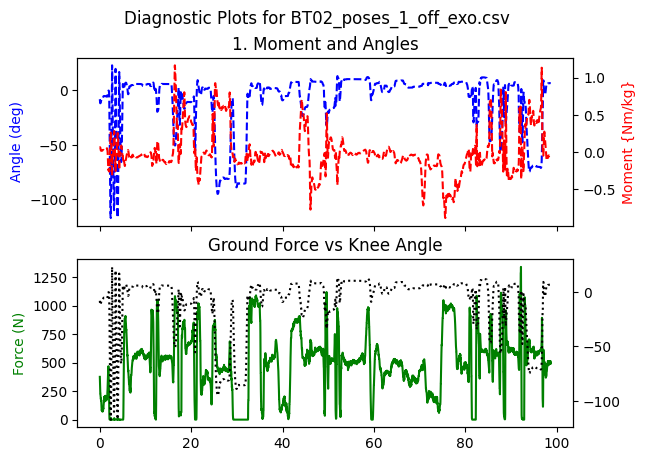

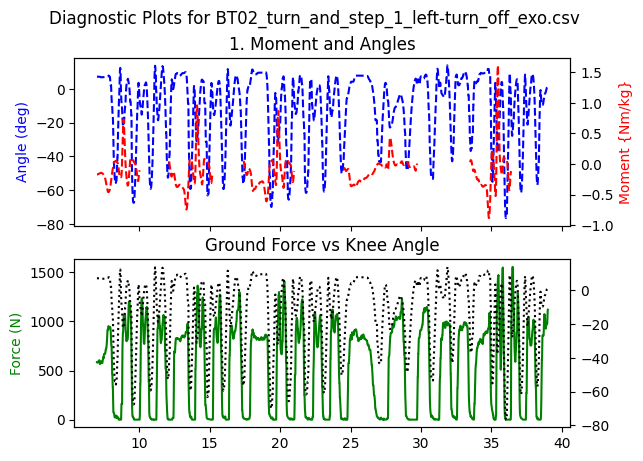

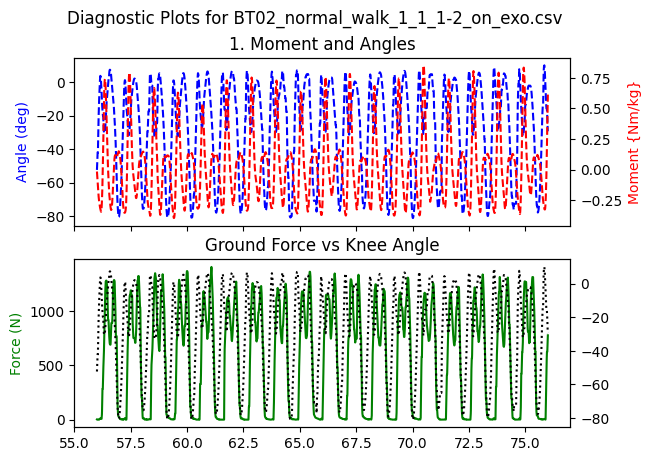

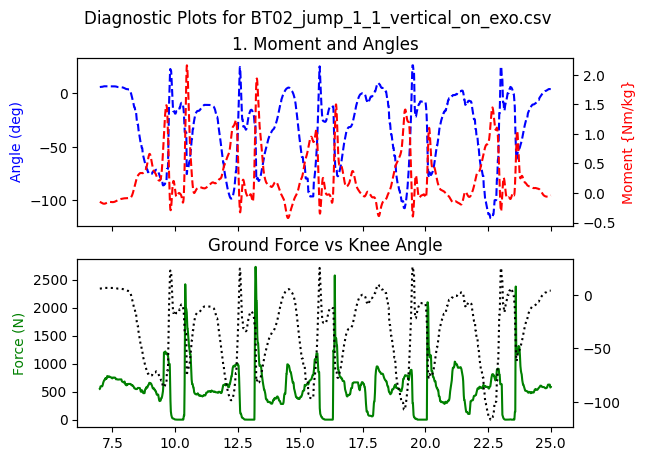

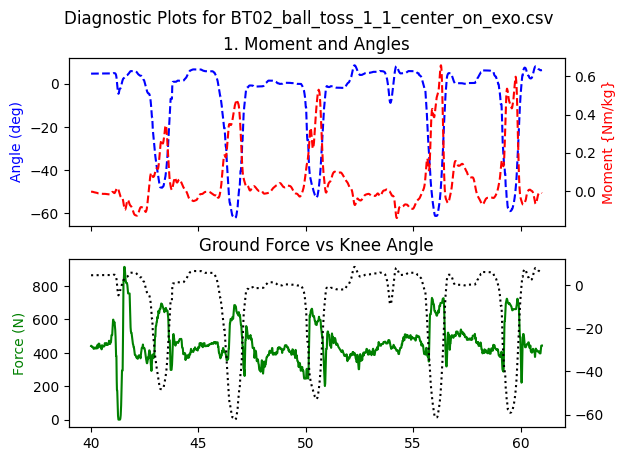

In [ ]:
data_path = "Phase1And2_Parsed/BT02"
generate_diagnostic_plots(data_path)